<a href="https://colab.research.google.com/github/MehrdadJalali-AI/socialNetworkOptimization/blob/main/SOCAIL_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

         Function  Best Fitness  Worst Fitness  Mean Fitness       Std Dev  \
0          Sphere    617.561511    1299.658805    908.018296    217.638992   
1   Schwefel 2.22     11.416477      18.559527     15.368410      2.012187   
2    Schwefel 1.2    967.186011    5123.296418   2459.591518   1327.056169   
3   Schwefel 2.21     11.469130      20.362877     15.412602      2.323780   
4      Rosenbrock  14546.003424  144737.980041  64739.370472  46637.615743   
5            Step    577.000000    1893.000000   1120.400000    401.738771   
6         Quartic      0.075180       0.356589      0.167782      0.081117   
7   Schwefel 2.26   6053.372549    9987.930735   8037.116163   1217.645099   
8       Rastrigin     80.810912     159.422890    114.242829     21.553983   
9          Ackley      7.747325      12.224235     10.116089      1.272345   
10       Griewank      6.709070      15.731847     10.328584      2.756991   
11      Penalized      5.181604      11.838580      9.539264    

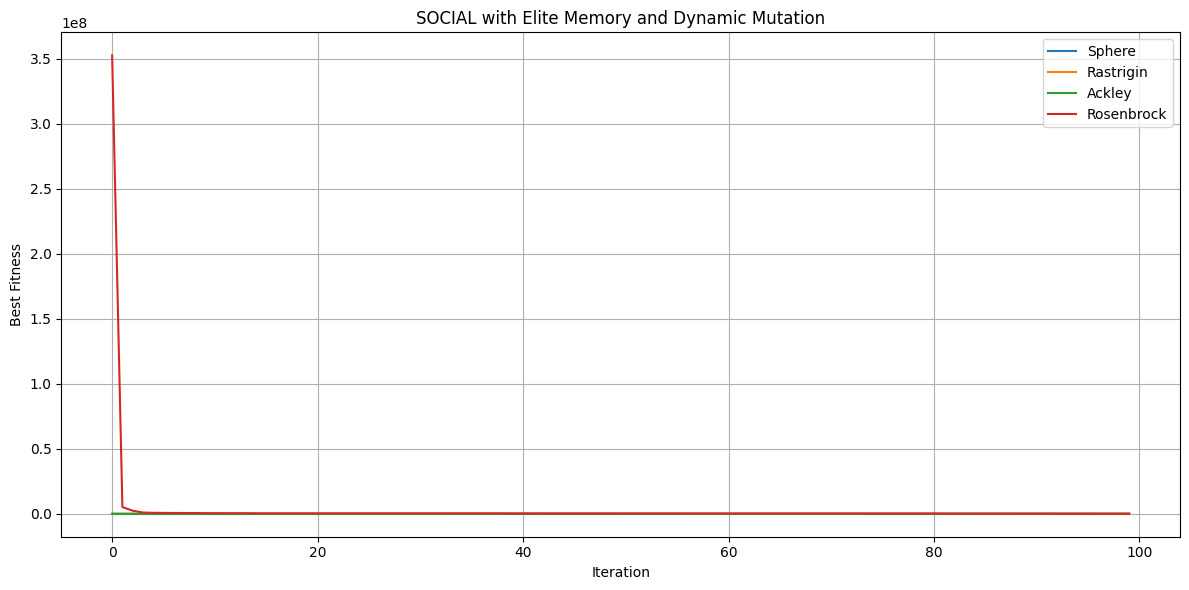

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- Benchmark Functions ---
def sphere(x): return sum(xi**2 for xi in x)
def schwefel_2_22(x): return sum(abs(xi) for xi in x) + np.prod([abs(xi) for xi in x])
def schwefel_1_2(x): return sum([sum(x[:i+1])**2 for i in range(len(x))])
def schwefel_2_21(x): return max(abs(xi) for xi in x)
def rosenbrock(x): return sum([100 * (x[i+1] - x[i]**2)**2 + (x[i] - 1)**2 for i in range(len(x)-1)])
def step(x): return sum(np.floor(xi + 0.5)**2 for xi in x)
def quartic(x): return sum((i+1) * xi**4 for i, xi in enumerate(x)) + np.random.uniform(0, 1)
def schwefel_2_26(x): return 418.9829 * len(x) - sum(xi * np.sin(np.sqrt(abs(xi))) for xi in x)
def rastrigin(x): return 10 * len(x) + sum(xi**2 - 10 * np.cos(2 * np.pi * xi) for xi in x)
def ackley(x):
    a, b, c = 20, 0.2, 2 * np.pi
    d = len(x)
    return -a * np.exp(-b * np.sqrt(sum(xi**2 for xi in x) / d)) - np.exp(sum(np.cos(c * xi) for xi in x) / d) + a + np.exp(1)
def griewank(x):
    sum_part = sum(xi**2 / 4000 for xi in x)
    prod_part = np.prod([np.cos(xi / np.sqrt(i + 1)) for i, xi in enumerate(x)])
    return sum_part - prod_part + 1
def penalized(x):
    n = len(x)
    y = [1 + (xi + 1) / 4 for xi in x]
    term1 = 10 * np.sin(np.pi * y[0])**2
    term2 = sum([(y[i] - 1)**2 * (1 + 10 * np.sin(np.pi * y[i+1])**2) for i in range(n-1)])
    term3 = (y[-1] - 1)**2
    u = sum([100 * (xi - 10)**4 if xi > 10 else (-xi - 10)**2 if xi < -10 else 0 for xi in x])
    return (np.pi / n) * (term1 + term2 + term3) + u
def penalized2(x):
    n = len(x)
    term1 = np.sin(3 * np.pi * x[0])**2
    term2 = sum([(x[i] - 1)**2 * (1 + np.sin(3 * np.pi * x[i+1])**2) for i in range(n-1)])
    term3 = (x[-1] - 1)**2 * (1 + np.sin(2 * np.pi * x[-1])**2)
    u = sum([100 * (xi - 10)**4 if xi > 10 else (-xi - 10)**2 if xi < -10 else 0 for xi in x])
    return 0.1 * (term1 + term2 + term3) + u
def alpine(x): return sum(abs(xi * np.sin(xi) + 0.1 * xi) for xi in x)

benchmark_functions = {
    "Sphere": sphere, "Schwefel 2.22": schwefel_2_22, "Schwefel 1.2": schwefel_1_2,
    "Schwefel 2.21": schwefel_2_21, "Rosenbrock": rosenbrock, "Step": step,
    "Quartic": quartic, "Schwefel 2.26": schwefel_2_26, "Rastrigin": rastrigin,
    "Ackley": ackley, "Griewank": griewank, "Penalized": penalized,
    "Penalized2": penalized2, "Alpine": alpine
}

function_details = {
    "Sphere": (30, [-100, 100]), "Schwefel 2.22": (30, [-10, 10]), "Schwefel 1.2": (30, [-100, 100]),
    "Schwefel 2.21": (30, [-100, 100]), "Rosenbrock": (30, [-30, 30]), "Step": (30, [-100, 100]),
    "Quartic": (30, [-1.28, 1.28]), "Schwefel 2.26": (30, [-500, 500]), "Rastrigin": (30, [-5.12, 5.12]),
    "Ackley": (30, [-32, 32]), "Griewank": (30, [-600, 600]), "Penalized": (30, [-50, 50]),
    "Penalized2": (30, [-50, 50]), "Alpine": (30, [-10, 10])
}

# --- Refined SOCIAL Core Functions ---
def initialize_population_social(num_nodes, dim, bounds):
    G = nx.watts_strogatz_graph(num_nodes, k=4, p=0.3)
    for node in G.nodes:
        G.nodes[node]['position'] = np.random.uniform(bounds[0], bounds[1], dim)
        G.nodes[node]['fitness'] = None
    return G

def evaluate_fitness_social(G, func):
    for node in G.nodes:
        pos = G.nodes[node]['position']
        G.nodes[node]['fitness'] = func(pos)
    return len(G.nodes)

def diffuse_information(G, gbest_pos, elite_pos, alpha, beta, gamma, delta, bounds, iteration, max_iterations):
    centrality = nx.betweenness_centrality(G)
    fitness_values = np.array([G.nodes[n]['fitness'] for n in G.nodes])
    max_fitness = max(fitness_values) + 1e-6
    influence = 1 - (fitness_values / max_fitness)

    # Dynamic parameters
    alpha_t = alpha * (1 - iteration / max_iterations)
    beta_t = beta * (1 - iteration / max_iterations)
    gamma_t = gamma * (iteration / max_iterations)
    delta_t = delta * (iteration / max_iterations)  # Elite influence increases over time

    new_positions = {}
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            new_positions[node] = G.nodes[node]['position']
            continue

        weights = [alpha_t * centrality[n] + beta_t * influence[n] for n in neighbors]
        weights = np.array(weights)
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
        neighbor_positions = [G.nodes[n]['position'] for n in neighbors]
        neighbor_contribution = np.average(neighbor_positions, weights=weights, axis=0)

        # Combine self, neighbor, gbest, and elite contributions
        new_pos = (
            G.nodes[node]['position'] * (1 - alpha_t - beta_t - gamma_t - delta_t) +
            neighbor_contribution * (alpha_t + beta_t) +
            gbest_pos * gamma_t +
            elite_pos * delta_t
        )
        new_positions[node] = np.clip(new_pos, bounds[0], bounds[1])

    # Dynamic mutation: strength decreases over iterations
    median_fitness = np.median(fitness_values)
    mutation_rate = 0.1  # Fixed probability
    mutation_strength = 0.1 * (1 - iteration / max_iterations) + 0.01  # Decays from 10% to 1%
    mutation_range = mutation_strength * (bounds[1] - bounds[0])
    for node in G.nodes:
        if G.nodes[node]['fitness'] > median_fitness and np.random.random() < mutation_rate:
            perturbation = np.random.uniform(-mutation_range, mutation_range, len(new_positions[node]))
            new_positions[node] = np.clip(new_positions[node] + perturbation, bounds[0], bounds[1])

    for node, pos in new_positions.items():
        G.nodes[node]['position'] = pos

def social_optimize(func, dim, bounds, num_nodes=30, iterations=100, alpha=0.4, beta=0.4, gamma=0.2, delta=0.1):
    G = initialize_population_social(num_nodes, dim, bounds)
    fitness_history = []
    total_evaluations = 0

    # Initialize global best and elite
    evaluate_fitness_social(G, func)
    fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
    gbest_idx = np.argmin(fitness_values)
    gbest_pos = G.nodes[gbest_idx]['position'].copy()
    gbest_fitness = fitness_values[gbest_idx]
    elite_pos = gbest_pos.copy()  # Elite starts as initial gbest
    elite_fitness = gbest_fitness

    for iteration in range(iterations):
        evaluations = evaluate_fitness_social(G, func)
        total_evaluations += evaluations

        # Update global best and elite
        fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
        min_fitness_idx = np.argmin(fitness_values)
        if fitness_values[min_fitness_idx] < gbest_fitness:
            gbest_pos = G.nodes[min_fitness_idx]['position'].copy()
            gbest_fitness = fitness_values[min_fitness_idx]
        if gbest_fitness < elite_fitness:  # Update elite if gbest improves
            elite_pos = gbest_pos.copy()
            elite_fitness = gbest_fitness

        diffuse_information(G, gbest_pos, elite_pos, alpha, beta, gamma, delta, bounds, iteration, iterations)
        fitness_history.append(gbest_fitness)

    best_solution = elite_pos  # Return elite as final best
    final_positions = np.array([G.nodes[n]['position'] for n in G.nodes])
    return fitness_history, best_solution, total_evaluations, final_positions

# --- Run on All Functions ---
num_runs = 10
max_iterations = 100
num_nodes = 30

results = []

for name, func in benchmark_functions.items():
    dim, bounds = function_details[name]
    all_histories = []
    all_final_pos = []
    best_fits = []

    for _ in range(num_runs):
        hist, _, _, final_positions = social_optimize(func, dim, bounds, num_nodes, max_iterations)
        all_histories.append(hist)
        best_fits.append(min(hist))
        all_final_pos.append(final_positions)

    mean_fit = np.mean(best_fits)
    std_fit = np.std(best_fits)
    diversity = np.mean([np.var(pos) for pos in all_final_pos])
    robustness = np.var(best_fits)
    convergence_speed = (num_nodes * max_iterations) / max_iterations  # Equal to num_nodes

    results.append({
        "Function": name,
        "Best Fitness": np.min(best_fits),
        "Worst Fitness": np.max(best_fits),
        "Mean Fitness": mean_fit,
        "Std Dev": std_fit,
        "Robustness": robustness,
        "Diversity": diversity,
        "Convergence Speed": convergence_speed
    })

# --- Save CSV ---
df_results = pd.DataFrame(results)
df_results.to_csv("SOCIAL_Results_Elite_Dynamic.csv", index=False)
print(df_results)

# --- Plot convergence for selected functions ---
selected = ["Sphere", "Rastrigin", "Ackley", "Rosenbrock"]
plt.figure(figsize=(12, 6))
for i, name in enumerate(selected):
    dim, bounds = function_details[name]
    hist, _, _, _ = social_optimize(benchmark_functions[name], dim, bounds)
    plt.plot(hist, label=name)
plt.xlabel("Iteration")
plt.ylabel("Best Fitness")
plt.title("SOCIAL with Elite Memory and Dynamic Mutation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Final Best Fitness: 0.000002


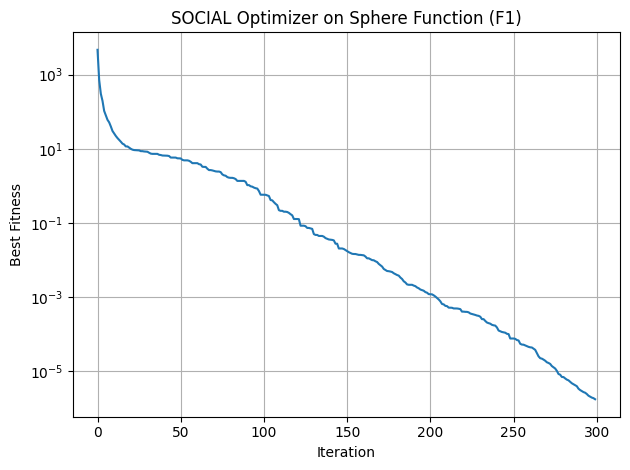

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# --- Sphere Function (F1) ---
def sphere(x): return sum(xi**2 for xi in x)

# --- Initialize Graph and Population ---
def initialize_population(num_nodes, dim, bounds):
    G = nx.watts_strogatz_graph(num_nodes, k=4, p=0.3)
    for node in G.nodes:
        G.nodes[node]['position'] = np.random.uniform(bounds[0], bounds[1], dim)
        G.nodes[node]['fitness'] = None
    return G

# --- Evaluate Fitness ---
def evaluate_fitness(G, func):
    for node in G.nodes:
        pos = G.nodes[node]['position']
        G.nodes[node]['fitness'] = func(pos)

# --- Diffusion with Centrality and Mutation ---
def diffuse(G, gbest_pos, elite_pos, alpha, beta, gamma, delta, bounds, iteration, max_iterations, enable_mutation=True):
    centrality = nx.betweenness_centrality(G)
    fitness_values = np.array([G.nodes[n]['fitness'] for n in G.nodes])
    influence = 1 - (fitness_values / (max(fitness_values) + 1e-6))

    # Dynamic weights (no normalization)
    alpha_t = alpha * (1 - iteration / max_iterations)
    beta_t  = beta  * (1 - iteration / max_iterations)
    gamma_t = gamma * (iteration / max_iterations)
    delta_t = delta * (iteration / max_iterations)

    new_positions = {}
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            new_positions[node] = G.nodes[node]['position']
            continue

        weights = [alpha_t * centrality[n] + beta_t * influence[i] for i, n in enumerate(neighbors)]
        weights = np.array(weights)
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
        neighbor_positions = [G.nodes[n]['position'] for n in neighbors]
        neighbor_contribution = np.average(neighbor_positions, weights=weights, axis=0)

        # Updated position using weighted sum
        new_pos = (
            G.nodes[node]['position'] * (1 - alpha_t - beta_t - gamma_t - delta_t) +
            neighbor_contribution * (alpha_t + beta_t) +
            gbest_pos * gamma_t +
            elite_pos * delta_t
        )
        new_positions[node] = np.clip(new_pos, bounds[0], bounds[1])

    # Dynamic mutation (optional)
    if enable_mutation:
        mutation_rate = 0.1
        mutation_strength = 0.1 * (1 - iteration / max_iterations) + 0.01
        mutation_range = mutation_strength * (bounds[1] - bounds[0])
        median_fitness = np.median(fitness_values)

        for node in G.nodes:
            pos = new_positions[node]
            if G.nodes[node]['fitness'] > median_fitness and np.random.rand() < mutation_rate:
                perturb = np.random.uniform(-mutation_range, mutation_range, len(pos))
                pos = np.clip(pos + perturb, bounds[0], bounds[1])
                #print(f"Mutation applied at iteration {iteration} on node {node}")
            G.nodes[node]['position'] = pos
    else:
        for node, pos in new_positions.items():
            G.nodes[node]['position'] = pos

# --- SOCIAL Optimizer (Sphere Only) ---
def social_optimize_sphere(dim=30, bounds=[-30, 30], num_nodes=1000, iterations=300, enable_mutation=True):
    func = sphere
    alpha, beta, gamma, delta = 0.4, 0.4, 0.2, 0.2
    G = initialize_population(num_nodes, dim, bounds)

    evaluate_fitness(G, func)
    fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
    gbest_idx = np.argmin(fitness_values)
    gbest_pos = G.nodes[gbest_idx]['position'].copy()
    gbest_fitness = fitness_values[gbest_idx]
    elite_pos = gbest_pos.copy()
    elite_fitness = gbest_fitness

    fitness_history = []

    for iteration in range(iterations):
        evaluate_fitness(G, func)
        fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]

        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < gbest_fitness:
            gbest_pos = G.nodes[min_idx]['position'].copy()
            gbest_fitness = fitness_values[min_idx]

        if gbest_fitness < elite_fitness:
            elite_pos = gbest_pos.copy()
            elite_fitness = gbest_fitness

        fitness_history.append(elite_fitness)
        #print(f"Iteration {iteration+1}: Elite Fitness = {elite_fitness:.6f}")

        diffuse(G, gbest_pos, elite_pos, alpha, beta, gamma, delta, bounds, iteration, iterations, enable_mutation)

    return fitness_history, elite_pos, elite_fitness

# --- Run and Plot ---
history, best_pos, best_fit = social_optimize_sphere()
print(f"\nFinal Best Fitness: {best_fit:.6f}")

plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Best Fitness")
plt.title("SOCIAL Optimizer on Sphere Function (F1)")
plt.yscale('log')  # Use log scale to show convergence trend clearly
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# --- Configuration (Hyperparameters) ---
class Config:
    # General parameters
    DIM = 30
    NUM_NODES = 100
    ITERATIONS = 2000
    NUM_RUNS = 100

    # Graph parameters
    K = 4                  # Number of nearest neighbors in Watts-Strogatz graph
    P = 0.3                # Rewiring probability in Watts-Strogatz graph

    # Diffusion weights
    ALPHA = 0.4            # Centrality weight
    BETA = 0.4             # Influence weight
    GAMMA = 0.2            # Global best weight
    DELTA = 0.2            # Elite best weight

    # Mutation parameters
    MUTATION_RATE = 0.1    # Probability of mutation
    MUTATION_STRENGTH_BASE = 0.1  # Initial mutation strength
    MUTATION_STRENGTH_MIN = 0.01  # Minimum mutation strength

# --- Benchmark Functions (F1-F13) ---
def sphere(x): return np.sum(x**2)
def schwefel_2_22(x): return np.sum(np.abs(x)) + np.prod(np.abs(x))
def schwefel_1_2(x): return np.sum([np.sum(x[:i+1])**2 for i in range(len(x))])
def schwefel_2_21(x): return np.max(np.abs(x))
def rosenbrock(x): return np.sum([100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1)])
def step(x): return np.sum(np.floor(x + 0.5)**2)
def quartic(x): return np.sum([(i+1) * xi**4 for i, xi in enumerate(x)]) + np.random.uniform(0, 1)
def schwefel_2_26(x): return 418.9829 * len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x))))
def rastrigin(x): return 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))
def ackley(x):
    a, b, c = 20, 0.2, 2 * np.pi
    d = len(x)
    return -a * np.exp(-b * np.sqrt(np.sum(x**2) / d)) - np.exp(np.sum(np.cos(c * x)) / d) + a + np.e
def griewank(x): return np.sum(x**2) / 4000 - np.prod(np.cos(x / np.sqrt(np.arange(1, len(x)+1)))) + 1
def penalized(x):
    y = 1 + (x + 1) / 4
    term1 = 10 * np.sin(np.pi * y[0])**2
    term2 = np.sum([(y[i] - 1)**2 * (1 + 10 * np.sin(np.pi * y[i+1])**2) for i in range(len(x)-1)])
    term3 = (y[-1] - 1)**2
    u = np.sum([100 * (xi - 10)**4 if xi > 10 else (-10 - xi)**4 if xi < -10 else 0 for xi in x])
    return (np.pi / len(x)) * (term1 + term2 + term3) + u
def penalized2(x):
    term1 = np.sin(3 * np.pi * x[0])**2
    term2 = np.sum([(x[i] - 1)**2 * (1 + np.sin(3 * np.pi * x[i+1])**2) for i in range(len(x)-1)])
    term3 = (x[-1] - 1)**2 * (1 + np.sin(2 * np.pi * x[-1])**2)
    u = np.sum([0.1 * (xi - 5)**4 if xi > 5 else (-5 - xi)**4 if xi < -5 else 0 for xi in x])
    return 0.1 * (term1 + term2 + term3) + u

# --- Function List and Bounds ---
FUNCTIONS = {
    'Sphere': (sphere, [-100, 100]),
    'Schwefel_2_22': (schwefel_2_22, [-10, 10]),
    'Schwefel_1_2': (schwefel_1_2, [-100, 100]),
    'Schwefel_2_21': (schwefel_2_21, [-100, 100]),
    'Rosenbrock': (rosenbrock, [-30, 30]),
    'Step': (step, [-100, 100]),
    'Quartic': (quartic, [-1.28, 1.28]),
    'Schwefel_2_26': (schwefel_2_26, [-500, 500]),
    'Rastrigin': (rastrigin, [-5.12, 5.12]),
    'Ackley': (ackley, [-32, 32]),
    'Griewank': (griewank, [-600, 600]),
    'Penalized': (penalized, [-50, 50]),
    'Penalized2': (penalized2, [-50, 50])
}

# --- Initialize Graph and Population ---
def initialize_population(num_nodes, dim, bounds):
    G = nx.watts_strogatz_graph(num_nodes, k=Config.K, p=Config.P)
    for node in G.nodes:
        G.nodes[node]['position'] = np.random.uniform(bounds[0], bounds[1], dim)
        G.nodes[node]['fitness'] = None
    return G

# --- Evaluate Fitness ---
def evaluate_fitness(G, func):
    for node in G.nodes:
        pos = G.nodes[node]['position']
        G.nodes[node]['fitness'] = func(pos)

# --- Diffusion with Centrality and Mutation ---
def diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, max_iterations, enable_mutation=True):
    centrality = nx.betweenness_centrality(G)
    fitness_values = np.array([G.nodes[n]['fitness'] for n in G.nodes])
    influence = 1 - (fitness_values / (max(fitness_values) + 1e-6))

    alpha_t = config.ALPHA * (1 - iteration / max_iterations)
    beta_t  = config.BETA  * (1 - iteration / max_iterations)
    gamma_t = config.GAMMA * (iteration / max_iterations)
    delta_t = config.DELTA * (iteration / max_iterations)

    new_positions = {}
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            new_positions[node] = G.nodes[node]['position']
            continue

        weights = [alpha_t * centrality[n] + beta_t * influence[i] for i, n in enumerate(neighbors)]
        weights = np.array(weights)
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
        neighbor_positions = [G.nodes[n]['position'] for n in neighbors]
        neighbor_contribution = np.average(neighbor_positions, weights=weights, axis=0)

        new_pos = (
            G.nodes[node]['position'] * (1 - alpha_t - beta_t - gamma_t - delta_t) +
            neighbor_contribution * (alpha_t + beta_t) +
            gbest_pos * gamma_t +
            elite_pos * delta_t
        )
        new_positions[node] = np.clip(new_pos, bounds[0], bounds[1])

    if enable_mutation:
        mutation_strength = config.MUTATION_STRENGTH_BASE * (1 - iteration / max_iterations) + config.MUTATION_STRENGTH_MIN
        mutation_range = mutation_strength * (bounds[1] - bounds[0])
        median_fitness = np.median(fitness_values)

        for node in G.nodes:
            pos = new_positions[node]
            if G.nodes[node]['fitness'] > median_fitness and np.random.rand() < config.MUTATION_RATE:
                perturb = np.random.uniform(-mutation_range, mutation_range, len(pos))
                pos = np.clip(pos + perturb, bounds[0], bounds[1])
            G.nodes[node]['position'] = pos
    else:
        for node, pos in new_positions.items():
            G.nodes[node]['position'] = pos

# --- SOCIAL Optimizer ---
def social_optimize(func_name, config=Config(), enable_mutation=True):
    func, bounds = FUNCTIONS[func_name]
    G = initialize_population(config.NUM_NODES, config.DIM, bounds)

    evaluate_fitness(G, func)
    fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
    gbest_idx = np.argmin(fitness_values)
    gbest_pos = G.nodes[gbest_idx]['position'].copy()
    gbest_fitness = fitness_values[gbest_idx]
    elite_pos = gbest_pos.copy()
    elite_fitness = gbest_fitness

    fitness_history = []

    for iteration in range(config.ITERATIONS):
        evaluate_fitness(G, func)
        fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]

        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < gbest_fitness:
            gbest_pos = G.nodes[min_idx]['position'].copy()
            gbest_fitness = fitness_values[min_idx]

        if gbest_fitness < elite_fitness:
            elite_pos = gbest_pos.copy()
            elite_fitness = gbest_fitness

        fitness_history.append(elite_fitness)
        diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, config.ITERATIONS, enable_mutation)

    return fitness_history, elite_pos, elite_fitness, G

# --- Run, Compute Metrics, and Save to CSV ---
def run_all_functions(config=Config()):
    results = []

    for name, (func, bounds) in FUNCTIONS.items():
        best_fits = []
        all_histories = []
        final_populations = []

        for _ in range(config.NUM_RUNS):
            history, _, best_fit, G = social_optimize(name, config)
            best_fits.append(best_fit)
            all_histories.append(history)
            final_populations.append(G)

        # Compute metrics
        best_fits = np.array(best_fits)
        mean_fit = np.mean(best_fits)
        std_fit = np.std(best_fits)
        robustness = std_fit**2
        diversity = np.mean([np.mean([np.std([G.nodes[n]['position'][i] for n in G.nodes]) for i in range(config.DIM)]) for G in final_populations])
        convergence_speed = next((i for i, fit in enumerate(all_histories[0]) if fit < mean_fit + std_fit), config.ITERATIONS)

        results.append({
            "Function": name,
            "Best Fitness": np.min(best_fits),
            "Worst Fitness": np.max(best_fits),
            "Mean Fitness": mean_fit,
            "Std Dev": std_fit,
            "Robustness": robustness,
            "Diversity": diversity,
            "Convergence Speed": convergence_speed
        })
        print(f"{name} - Best: {np.min(best_fits):.6f}, Mean: {mean_fit:.6f}, Std Dev: {std_fit:.6f}")

    # Save to CSV
    df = pd.DataFrame(results)
    df.to_csv('social_results.csv', index=False)
    print("\nResults saved to 'social_results.csv'")

    # Plot convergence
    plt.figure(figsize=(12, 8))
    for name in FUNCTIONS.keys():
        history = next(r["Mean Fitness"] for r in results if r["Function"] == name)
        plt.plot(all_histories[0], label=name)  # Using first run's history for plotting
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness")
    plt.title("SOCIAL Optimizer on Benchmark Functions (F1-F13)")
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

# --- Execute ---
if __name__ == "__main__":
    config = Config()
    results = run_all_functions(config)

Sphere - Best: 0.000000, Mean: 0.000000, Std Dev: 0.000000
Schwefel_2_22 - Best: 0.705217, Mean: 1.223352, Std Dev: 0.526425
Schwefel_1_2 - Best: 0.396531, Mean: 0.615660, Std Dev: 0.198123
Schwefel_2_21 - Best: 1.703657, Mean: 2.913851, Std Dev: 1.254686
Rosenbrock - Best: 26.628561, Mean: 28.141255, Std Dev: 0.753207
Step - Best: 1.000000, Mean: 4.800000, Std Dev: 2.561250
Quartic - Best: 0.000549, Mean: 0.000867, Std Dev: 0.000201
Schwefel_2_26 - Best: 4509.611766, Mean: 5632.378870, Std Dev: 486.456794
Rastrigin - Best: 3.979836, Mean: 12.834968, Std Dev: 8.113030
Ackley - Best: 0.000678, Mean: 2.582869, Std Dev: 1.179304
Griewank - Best: 0.000016, Mean: 0.008708, Std Dev: 0.013250
Penalized - Best: 0.000001, Mean: 0.426664, Std Dev: 0.394891
Penalized2 - Best: 0.000000, Mean: 0.020633, Std Dev: 0.031978

Results saved to 'social_results.csv'


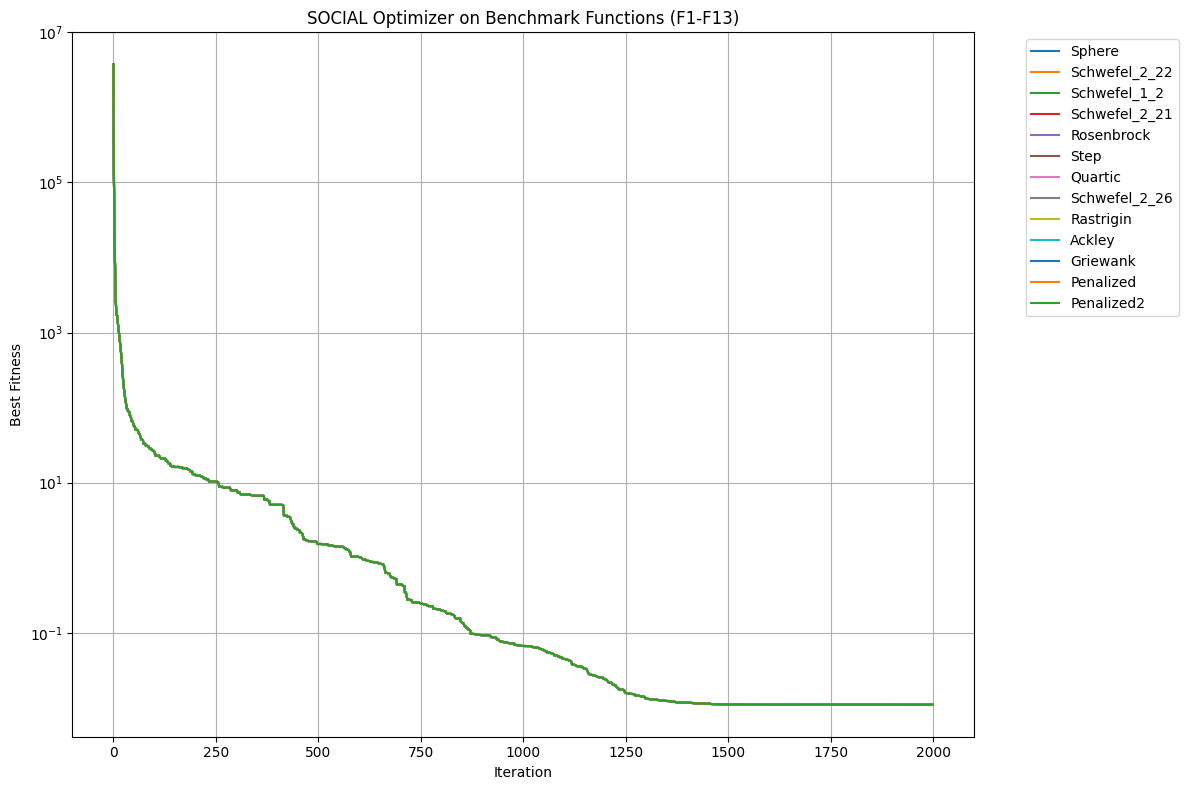

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# --- Configuration (Hyperparameters) ---
class Config:
    # General parameters
    DIM = 30
    NUM_NODES = 200
    ITERATIONS = 2000
    NUM_RUNS = 10

    # Graph parameters
    K = 3                  # Number of nearest neighbors in Watts-Strogatz graph
    P = 0.1                # Rewiring probability in Watts-Strogatz graph

    # Diffusion weights
    ALPHA = 0.4            # Centrality weight
    BETA = 0.4             # Influence weight
    GAMMA = 0.2            # Global best weight
    DELTA = 0.2            # Elite best weight

    # Mutation parameters
    MUTATION_RATE = 0.1    # Probability of mutation
    MUTATION_STRENGTH_BASE = 0.1  # Initial mutation strength
    MUTATION_STRENGTH_MIN = 0.01  # Minimum mutation strength

# --- Benchmark Functions (F1-F13) ---
def sphere(x): return np.sum(x**2)
def schwefel_2_22(x): return np.sum(np.abs(x)) + np.prod(np.abs(x))
def schwefel_1_2(x): return np.sum([np.sum(x[:i+1])**2 for i in range(len(x))])
def schwefel_2_21(x): return np.max(np.abs(x))
def rosenbrock(x): return np.sum([100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1)])
def step(x): return np.sum(np.floor(x + 0.5)**2)
def quartic(x): return np.sum([(i+1) * xi**4 for i, xi in enumerate(x)]) + np.random.uniform(0, 1)
def schwefel_2_26(x): return 418.9829 * len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x))))
def rastrigin(x): return 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))
def ackley(x):
    a, b, c = 20, 0.2, 2 * np.pi
    d = len(x)
    return -a * np.exp(-b * np.sqrt(np.sum(x**2) / d)) - np.exp(np.sum(np.cos(c * x)) / d) + a + np.e
def griewank(x): return np.sum(x**2) / 4000 - np.prod(np.cos(x / np.sqrt(np.arange(1, len(x)+1)))) + 1
def penalized(x):
    y = 1 + (x + 1) / 4
    term1 = 10 * np.sin(np.pi * y[0])**2
    term2 = np.sum([(y[i] - 1)**2 * (1 + 10 * np.sin(np.pi * y[i+1])**2) for i in range(len(x)-1)])
    term3 = (y[-1] - 1)**2
    u = np.sum([100 * (xi - 10)**4 if xi > 10 else (-10 - xi)**4 if xi < -10 else 0 for xi in x])
    return (np.pi / len(x)) * (term1 + term2 + term3) + u
def penalized2(x):
    term1 = np.sin(3 * np.pi * x[0])**2
    term2 = np.sum([(x[i] - 1)**2 * (1 + np.sin(3 * np.pi * x[i+1])**2) for i in range(len(x)-1)])
    term3 = (x[-1] - 1)**2 * (1 + np.sin(2 * np.pi * x[-1])**2)
    u = np.sum([0.1 * (xi - 5)**4 if xi > 5 else (-5 - xi)**4 if xi < -5 else 0 for xi in x])
    return 0.1 * (term1 + term2 + term3) + u

# --- Function List and Bounds ---
FUNCTIONS = {
    'Sphere': (sphere, [-100, 100]),
    'Schwefel_2_22': (schwefel_2_22, [-10, 10]),
    'Schwefel_1_2': (schwefel_1_2, [-100, 100]),
    'Schwefel_2_21': (schwefel_2_21, [-100, 100]),
    'Rosenbrock': (rosenbrock, [-30, 30]),
    'Step': (step, [-100, 100]),
    'Quartic': (quartic, [-1.28, 1.28]),
    'Schwefel_2_26': (schwefel_2_26, [-500, 500]),
    'Rastrigin': (rastrigin, [-5.12, 5.12]),
    'Ackley': (ackley, [-32, 32]),
    'Griewank': (griewank, [-600, 600]),
    'Penalized': (penalized, [-50, 50]),
    'Penalized2': (penalized2, [-50, 50])
}

# --- Initialize Graph and Population ---
def initialize_population(num_nodes, dim, bounds):
    G = nx.watts_strogatz_graph(num_nodes, k=Config.K, p=Config.P)
    for node in G.nodes:
        G.nodes[node]['position'] = np.random.uniform(bounds[0], bounds[1], dim)
        G.nodes[node]['fitness'] = None
    return G

# --- Evaluate Fitness ---
def evaluate_fitness(G, func):
    for node in G.nodes:
        pos = G.nodes[node]['position']
        G.nodes[node]['fitness'] = func(pos)

# --- Diffusion with Centrality and Mutation ---
def diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, max_iterations, enable_mutation=True):

    centrality = nx.betweenness_centrality(G, k=10, seed=42)  # Fast approximation

    fitness_values = np.array([G.nodes[n]['fitness'] for n in G.nodes])
    influence = 1 - (fitness_values / (max(fitness_values) + 1e-6))

    alpha_t = config.ALPHA * (1 - iteration / max_iterations)
    beta_t  = config.BETA  * (1 - iteration / max_iterations)
    gamma_t = config.GAMMA * (iteration / max_iterations)
    delta_t = config.DELTA * (iteration / max_iterations)

    new_positions = {}
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            new_positions[node] = G.nodes[node]['position']
            continue

        weights = [alpha_t * centrality[n] + beta_t * influence[i] for i, n in enumerate(neighbors)]
        weights = np.array(weights)
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
        neighbor_positions = [G.nodes[n]['position'] for n in neighbors]
        neighbor_contribution = np.average(neighbor_positions, weights=weights, axis=0)

        new_pos = (
            G.nodes[node]['position'] * (1 - alpha_t - beta_t - gamma_t - delta_t) +
            neighbor_contribution * (alpha_t + beta_t) +
            gbest_pos * gamma_t +
            elite_pos * delta_t
        )
        new_positions[node] = np.clip(new_pos, bounds[0], bounds[1])

    if enable_mutation:
        mutation_strength = config.MUTATION_STRENGTH_BASE * (1 - iteration / max_iterations) + config.MUTATION_STRENGTH_MIN
        mutation_range = mutation_strength * (bounds[1] - bounds[0])
        median_fitness = np.median(fitness_values)

        for node in G.nodes:
            pos = new_positions[node]
            if G.nodes[node]['fitness'] > median_fitness and np.random.rand() < config.MUTATION_RATE:
                perturb = np.random.uniform(-mutation_range, mutation_range, len(pos))
                pos = np.clip(pos + perturb, bounds[0], bounds[1])
            G.nodes[node]['position'] = pos
    else:
        for node, pos in new_positions.items():
            G.nodes[node]['position'] = pos

# --- SOCIAL Optimizer ---
def social_optimize(func_name, config=Config(), enable_mutation=True):
    func, bounds = FUNCTIONS[func_name]
    G = initialize_population(config.NUM_NODES, config.DIM, bounds)

    evaluate_fitness(G, func)
    fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
    gbest_idx = np.argmin(fitness_values)
    gbest_pos = G.nodes[gbest_idx]['position'].copy()
    gbest_fitness = fitness_values[gbest_idx]
    elite_pos = gbest_pos.copy()
    elite_fitness = gbest_fitness

    fitness_history = []

    for iteration in range(config.ITERATIONS):
        evaluate_fitness(G, func)
        fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]

        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < gbest_fitness:
            gbest_pos = G.nodes[min_idx]['position'].copy()
            gbest_fitness = fitness_values[min_idx]

        if gbest_fitness < elite_fitness:
            elite_pos = gbest_pos.copy()
            elite_fitness = gbest_fitness

        fitness_history.append(elite_fitness)
        diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, config.ITERATIONS, enable_mutation)

    return fitness_history, elite_pos, elite_fitness, G

# --- Run, Compute Metrics, and Save to CSV ---
def run_all_functions(config=Config()):
    results = []

    for name, (func, bounds) in FUNCTIONS.items():
        best_fits = []
        all_histories = []
        final_populations = []

        for _ in range(config.NUM_RUNS):
            history, _, best_fit, G = social_optimize(name, config)
            best_fits.append(best_fit)
            all_histories.append(history)
            final_populations.append(G)

        # Compute metrics
        best_fits = np.array(best_fits)
        mean_fit = np.mean(best_fits)
        std_fit = np.std(best_fits)
        robustness = std_fit**2
        diversity = np.mean([np.mean([np.std([G.nodes[n]['position'][i] for n in G.nodes]) for i in range(config.DIM)]) for G in final_populations])
        convergence_speed = next((i for i, fit in enumerate(all_histories[0]) if fit < mean_fit + std_fit), config.ITERATIONS)

        results.append({
            "Function": name,
            "Best Fitness": np.min(best_fits),
            "Worst Fitness": np.max(best_fits),
            "Mean Fitness": mean_fit,
            "Std Dev": std_fit,
            "Robustness": robustness,
            "Diversity": diversity,
            "Convergence Speed": convergence_speed
        })
        print(f"{name} - Best: {np.min(best_fits):.6f}, Mean: {mean_fit:.6f}, Std Dev: {std_fit:.6f}")

    # Save to CSV
    df = pd.DataFrame(results)
    df.to_csv('social_results.csv', index=False)
    print("\nResults saved to 'social_results.csv'")

    # Plot convergence
    plt.figure(figsize=(12, 8))
    for name in FUNCTIONS.keys():
        history = next(r["Mean Fitness"] for r in results if r["Function"] == name)
        plt.plot(all_histories[0], label=name)  # Using first run's history for plotting
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness")
    plt.title("SOCIAL Optimizer on Benchmark Functions (F1-F13)")
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

# --- Execute ---
if __name__ == "__main__":
    config = Config()
    results = run_all_functions(config)